In [1]:
from pyspark.sql import SparkSession

import pandas as pd

from darts import TimeSeries
from darts.models import LinearRegressionModel
from darts.metrics import rmse
from darts.utils.missing_values import fill_missing_values

from pyspark.sql.functions import col, to_date, concat, lit, month, year, count, concat_ws,  date_trunc, when, trim, date_format, mean as _mean,  lag, sum as spark_sum, monotonically_increasing_id
from pyspark.ml.feature import StringIndexer

from pyspark.sql.window import Window

import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("TimeSeriesAnalysis").getOrCreate()

# Load the CSV file
data = spark.read.csv('bank_marketing.csv', header=True, inferSchema=True)

# Add an index column to retain the original order
data = data.withColumn("index", monotonically_increasing_id())
# Show the DataFrame with the new date column
data.show()


+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-----+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|index|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+-----+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|    0|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|    1|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|    2|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|    3|
| 33|     unknown|  single|  unknown|    

Data Cleaning

In [2]:
# Remove duplicates
data = data.dropDuplicates()

# Handle missing values
# For simplicity, filling numeric columns with the mean and string columns with 'unknown'
numeric_cols = [col_name for col_name, dtype in data.dtypes if dtype in ['int', 'double']]
string_cols = [col_name for col_name, dtype in data.dtypes if dtype == 'string']

# Fill numeric columns with mean
for col_name in numeric_cols:
    mean_val = data.select(_mean(col(col_name))).collect()[0][0]
    data = data.fillna(mean_val, subset=[col_name])

# Fill string columns with 'unknown'
data = data.fillna('unknown', subset=string_cols)

# Convert data types (example: converting a column 'age' to integer)
data = data.withColumn("age", col("age").cast("integer"))

# Trim whitespace from string columns
for col_name in string_cols:
    data = data.withColumn(col_name, trim(col(col_name)))

# Filter outliers (example: removing rows where 'age' > 100)
data = data.filter(col("age") <= 100)

data.show(100)
# End of Data Cleaning

+---+-------------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+-----+
|age|          job| marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|  y|index|
+---+-------------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+-----+
| 34|   technician| married|secondary|     no|     19|    yes|  no|  unknown|  5|  may|     362|       4|   -1|       0| unknown| no|  294|
| 30|   technician|  single|secondary|     no|    102|    yes|  no|  unknown|  7|  may|     614|       2|   -1|       0| unknown| no|  981|
| 37|   unemployed|divorced|  primary|     no|    849|    yes|  no|  unknown|  7|  may|     166|       1|   -1|       0| unknown| no|  990|
| 37|  blue-collar| married|secondary|     no|    105|    yes|  no|  unknown|  8|  may|      69|       2|   -1|       0| unknown| no| 1319|
| 33|       admin.| 

Preprocessing

In [3]:
# Sort the result to original order
window_spec = Window.orderBy("index")

# Calculate the previous month to determine year increment
data = data.withColumn("prev_month", lag("month").over(window_spec))

# Generate Year column as needed for Timeseries
data = data.withColumn(
    "month",
    when(col("month") == "jan", 1)
    .when(col("month") == "feb", 2)
    .when(col("month") == "mar", 3)
    .when(col("month") == "apr", 4)
    .when(col("month") == "may", 5)
    .when(col("month") == "jun", 6)
    .when(col("month") == "jul", 7)
    .when(col("month") == "aug", 8)
    .when(col("month") == "sep", 9)
    .when(col("month") == "oct", 10)
    .when(col("month") == "nov", 11)
    .when(col("month") == "dec", 12)
)

pdf = data.toPandas()
pdf['year'] = 2008
current_year = 2008

last_month = ''
years = []


for index, row in pdf.iterrows():    
    if row['month'] == 1 and last_month != 1:        
        current_year = current_year + 1         
    last_month = row['month']
    pdf.at[index, 'year'] = current_year

data = spark.createDataFrame(pdf) 

print(current_year)

# Create a proper timestamp column
data = data.withColumn("date_str", concat_ws("-", col("year"), col("month"), lit(1)))
data = data.withColumn("timestamp", date_format(col("date_str"), "yyyy-MM-dd"))

# Index the target variable
indexer = StringIndexer(inputCol="y", outputCol="y_index")
data = indexer.fit(data).transform(data)

# Define a window specification. Sort the result by index
window_spec = Window.orderBy("index")

# Calculate the previous month to determine year increment

data = data.drop('date_str', 'year', 'index', '_c0')
data.show(100)

2010
+---+-------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+----------+----------+-------+
|age|          job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|prev_month| timestamp|y_index|
+---+-------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+----------+----------+-------+
| 58|   management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|    5|     261|       1|   -1|       0| unknown| no|      NULL|2008-05-01|    0.0|
| 44|   technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|    5|     151|       1|   -1|       0| unknown| no|       may|2008-05-01|    0.0|
| 33| entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|    5|      76|       1|   -1|       0| unknown| no|       may|2008-05-01|    0.0|
| 47|  blue-collar| mar

In [4]:
# Convert categorical variables to numeric
categorical_columns = ['marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(data) for column in categorical_columns]

# Apply the StringIndexer transformations
for indexer in indexers:
    data = indexer.transform(data)

# Drop original categorical columns and keep only the indexed versions
data = data.drop(*categorical_columns)

# Convert 'y' column to binary (1 for 'yes', 0 for 'no')
data = data.withColumn('y_index', when(col('y') == 'yes', 1).otherwise(0))

# Select relevant features and convert to Pandas DataFrame for Darts
selected_columns = ['timestamp', 'y_index', 'poutcome_index', 'duration']
data_pd = data.select(*selected_columns).toPandas()

# Ensure the date column is in datetime format and set it as the index
#data_pd['timestamp'] = pd.to_datetime(data_pd['timestamp'], format='%Y-%m-%d')
#data_pd.set_index('timestamp', inplace=True)

# Handle duplicate dates by aggregating and taking the mean

data_pd['y_index'].fillna(0, inplace=True)
data_pd['poutcome_index'].fillna(0, inplace=True)
data_pd['duration'].fillna(0, inplace=True)

# Function to handle out of bounds dates
def safe_to_datetime(date_str, format='%Y-%m-%d'):
    try:
        return pd.to_datetime(date_str, format=format)
    except pd.errors.OutOfBoundsDatetime:
        return pd.NaT

# Apply the function to the timestamp column
data_pd['timestamp'] = data_pd['timestamp'].apply(safe_to_datetime)
data_pd = data_pd.groupby('timestamp').mean().reset_index()

data_pd.head(100)

,timestamp,y_index,poutcome_index,duration
0,2008-05-01,0.032424,0.000000,265.505844
1,2008-06-01,0.044806,0.000000,239.145118
2,2008-07-01,0.060188,0.000000,265.440596
3,2008-08-01,0.055225,0.000000,227.101055
4,2008-10-01,0.612500,0.150000,320.450000
5,2008-11-01,0.061145,0.326570,250.801556
6,2008-12-01,0.076923,0.000000,136.692308
7,2009-01-01,0.032313,0.426871,269.472789
8,2009-02-01,0.111063,0.410714,240.957753
9,2009-03-01,0.484496,0.131783,221.643411


In [5]:
# Using Dart Timeseries
# Create TimeSeries objects for the target and features, handling missing dates
series_y = TimeSeries.from_dataframe(data_pd, 'timestamp', 'y_index', fill_missing_dates=True, freq='d')
series_poutcome = TimeSeries.from_dataframe(data_pd, 'timestamp', 'poutcome_index', fill_missing_dates=True, freq='d')
series_duration = TimeSeries.from_dataframe(data_pd, 'timestamp', 'duration', fill_missing_dates=True, freq='d')

# Fill missing values in the series
series_y = fill_missing_values(series_y, method='linear')
series_poutcome = fill_missing_values(series_poutcome, method='linear')
series_duration = fill_missing_values(series_duration, method='linear')

In [6]:
# Split the data into training and testing sets
train_y, test_y = series_y.split_before(0.8)
train_poutcome, test_poutcome = series_poutcome.split_before(0.8)
train_duration, test_duration = series_duration.split_before(0.8)

# Combine features into a single multi-variate TimeSeries
train_features = TimeSeries.from_times_and_values(
    train_y.time_index, pd.concat([train_poutcome.pd_series(), train_duration.pd_series()], axis=1)
)
test_features = TimeSeries.from_times_and_values(
    test_y.time_index, pd.concat([test_poutcome.pd_series(), test_duration.pd_series()], axis=1)
)

In [7]:
# Initialize and train a Linear Regression Model
model = LinearRegressionModel(lags=None, lags_future_covariates=[0])
model.fit(train_y, future_covariates=train_features)

# Make predictions
predictions = model.predict(len(test_y), future_covariates=test_features)

In [8]:

from darts.metrics import mape, mae, mse, rmse

# Compute accuracy metrics
mape_value = mape(test_y, predictions)
mae_value = mae(test_y, predictions)
mse_value = mse(test_y, predictions)
rmse_value = rmse(test_y, predictions)

# Print accuracy metrics
print(f'MAPE (Mean Absolute Percentage Error) {mape_value:.2f}% ')
print(f'MAE (Mean Absolute Error): {mae_value:.2f}')
print(f'MSE (Mean Squared Error): {mse_value:.2f}')
print(f'RMSE (Root Mean Squared Error): {rmse_value:.2f}')

accuracy = 100 - mape_value
print(f'Accuracy: {accuracy:.2f}%')

MAPE (Mean Absolute Percentage Error) 8.33% 
MAE (Mean Absolute Error): 0.04
MSE (Mean Squared Error): 0.00
RMSE (Root Mean Squared Error): 0.06
Accuracy: 91.67%


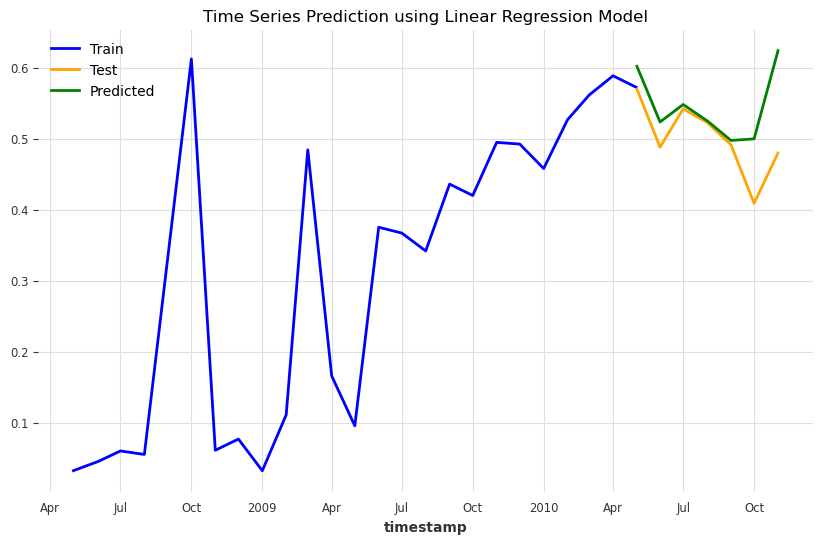

In [9]:
# Plot the train, test, and predicted data
plt.figure(figsize=(10, 6))
train_y.plot(label="Train", color='blue')
test_y.plot(label="Test", color='orange')
predictions.plot(label="Predicted", color='green')
plt.title("Time Series Prediction using Linear Regression Model")
plt.legend()
plt.show()



In [10]:

# Stop the Spark session
spark.stop()